In [1]:
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:
# Define model params
batch_size = 10
n_iter_sinkhorn2 = 10
n_iter_sinkhorn = 200

temp = 0.001
temp2 =0.00001

#mnist data
n_squares_side = 16
lr = 0.01
n_channels = 1
rfield_size = 3
stride = 3
n_units = 5
keep_prob = 1.0
side_real = 28
opt = 'adam'
samples_per_num = 1
n_squares = n_squares_side **2
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)
print(n_dim)
n_dim_z = 5
n_dim_z2 = 5
n_dim_zp = 2
noise_factor = 0
np.random.seed(2)



25


In [4]:
#Now we define the main TF variables


real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])
real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2* n_channels])

real_entire = tf.placeholder(tf.float32,[None, side_real, side_real, n_channels])
real_entire_tiled = tf.tile(real_entire,[samples_per_num,1,1,1])

global_step = tf.Variable(0, trainable=False)



In [5]:

def create_z():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(-1))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image, scope, n_dim_z):
        with tf.variable_scope(scope):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output_mean = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
        fully_connected_output_log_var = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
      
        return fully_connected_output_mean, fully_connected_output_log_var
    
    #with tf.variable_scope("model_params"):
    z_mean, z_log_var = conv_and_fc(real_entire_tiled,'n1', n_dim_z)
    z_mean_pieces, z_log_var_pieces = conv_and_fc(real_entire_tiled,'n2',n_dim_zp)
    z_mean_pieces = tf.reshape(tf.tile(z_mean_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    
    z_log_var_pieces = tf.reshape(tf.tile(z_log_var_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    z_pieces = z_mean_pieces + tf.random.normal([batch_size*n_squares, n_dim_zp]) *tf.exp(z_log_var_pieces/2)
    aa = fc(z_pieces,1, activation_fn = None)
    #z_pieces_fc = 1/(1+tf.exp(-aa/temp))
    Bernoulli = tf.contrib.distributions.Bernoulli
    z_pieces_fc = Bernoulli(logits=aa/temp).mean()
    scrambled_split_tiled = tf.tile(tf.reshape(z_pieces_fc, [batch_size, n_squares, 1]), [1,1, n_channels*side_square**2])
    
    z  = z_mean + tf.random.normal([batch_size, n_dim_z]) *tf.exp(z_log_var/2)
    z1 = tf.reshape(fc(z, n_squares*n_dim_z2), [-1, n_squares, n_dim_z2])
    z2 = tf.reshape(fc(flatten(z_pieces), n_dim_z2), [-1,  n_dim_z2,  n_squares])
    cost = tf.matmul(z1,z2)
   
    return z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled, aa,z_pieces_fc

In [6]:


#ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)

z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled,aa,z_pieces_fc = create_z()
(soft_perms_inf2, _) = sinkhorn_ops.gumbel_sinkhorn(-cost, temp2, samples_per_num, noise_factor, n_iter_sinkhorn2, squeeze=False)
inv_soft_perms2 = tf.transpose(soft_perms_inf2, [0, 1, 3, 2])
inv_soft_perms2_flat = tf.reshape(tf.transpose(inv_soft_perms2, [1, 0, 2, 3]), [-1, n_squares, n_squares])

ordered_inf2 = tf.matmul(inv_soft_perms2_flat, scrambled_split_tiled)
 
#rec_loss =tf.reduce_mean(tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled), axis=1))*side_real**2
rec_loss =-tf.reduce_mean(tf.reduce_mean(real_split_tiled*tf.log(1e-5+ordered_inf2) +(1-real_split_tiled)*tf.log(1e-5+1-ordered_inf2),axis=0))*side_real**2

KL1 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var -tf.square(z_mean) -tf.exp(z_log_var), axis=1))
KL2 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var_pieces -tf.square(z_mean_pieces) -tf.exp(z_log_var_pieces), axis=1))
KL = KL1+KL2*n_squares
l2s_diff = rec_loss - KL

#l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))

opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
new = tf.trainable_variables()
print(new)
n_iter = 200
for i in range(n_iter):
    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    
    [o2,loss, rec_loss_np,KL_np,_, sp2,cos,z_mean_pieces_np, z_pieces_fc_np,z_log_var_pieces_np,aa_np] = sess.run([ordered_inf2, l2s_diff,rec_loss,KL, train_op, soft_perms_inf2,cost,z_mean_pieces,z_pieces_fc,z_log_var_pieces,aa],{real_split:real_images_split,real_entire:ims})
    if(i%10==0):
        print([i, loss])
    if i==n_iter-1:
        ogen = []
        sgen =[]
        for k in range(5):
            [oo2,ssp2,scrambled_pieces_split_np] = sess.run([ordered_inf2,soft_perms_inf2, scrambled_split_tiled],{z:np.random.normal(0,1,(batch_size, n_dim_z)),
                                                                 z_pieces:np.random.normal(0,1,(n_squares*batch_size, n_dim_zp))})
            ogen.append(oo2)
            sgen.append(ssp2)

   


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[<tf.Variable 'n1/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n1/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected/weights:0' shape=(500, 5) dtype=float32_ref>, <tf.Variable 'fully_connected/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(500, 5) dtype=float32_ref>, <tf.Variable 'fully_connected_1/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'n2/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n2/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(500, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(500, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_3/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_4/weights:0' shape=(2, 1) dtype=float32_ref>,

/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[0, 4799.5205]
[10, 1703.0856]
[20, 1558.9323]
[30, 1968.5358]
[40, 1695.6353]
[50, 1432.8304]
[60, 1065.4485]
[70, 772.049]
[80, 596.15015]
[90, 561.4052]
[100, 638.94293]
[110, 558.7658]
[120, 462.84418]
[130, 445.68927]
[140, 466.06616]
[150, 428.2756]
[160, 441.49048]
[170, 479.55734]
[180, 398.20187]
[190, 502.64966]
hola


In [8]:
batch_size_display = 10
hard = np.zeros(sp2.shape)
ind=1
scrambled_pieces = unflatten_batch(scrambled_pieces_split_np, n_channels)
joined_scrambled = join_batch_split(scrambled_pieces)
for i in range(batch_size_display):
    hard[i,0,:,:] =soft_to_hard(np.transpose(sgen[ind][i,0,:,:]))
unscrambled_images_hard =  np.matmul(hard[:batch_size_display,0,:,:], np.reshape(scrambled_pieces[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
unscrambled_images_soft =  ogen[ind]
unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
joined_inf_hard = join_batch_split(unflatten_inf_hard)
unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
joined_inf_soft = join_batch_split(unflatten_inf_soft)


In [9]:
from scipy.special import softmax

print(aa_np/temp)
print(scrambled_pieces_split_np[0,:,0].T)

[[ 3166.715  ]
 [-1563.8119 ]
 [ 1196.4215 ]
 ...
 [  445.62057]
 [  459.823  ]
 [-1645.0281 ]]
[1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


(10, 80, 80, 1)


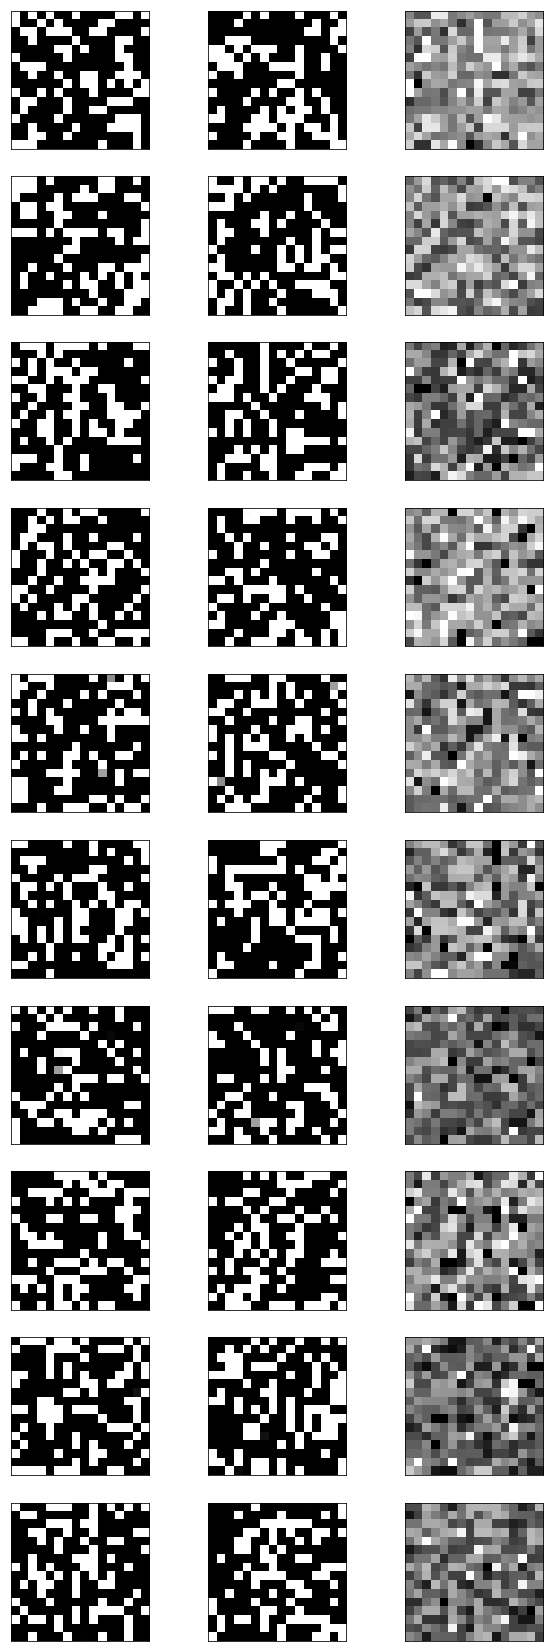

In [10]:
fig,ax=plt.subplots(10,3,figsize=(10,30))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)
for i in range(10):
    
    
    ax[i,1].imshow(joined_inf_hard[i,:,:,0],'gray')
    ax[i,2].imshow(joined_inf_soft[i,:,:,0],'gray')
    ax[i,0].imshow(joined_scrambled[i,:,:,0],'gray')
    for k in range(3):
        ax[i,k].get_xaxis().set_visible(False)
        ax[i,k].get_yaxis().set_visible(False)

In [11]:
print(np.max(ogen[1]))

0.7999999


[0.9441409  0.94609547 1.212537   1.2285135  1.0219297  0.96058095
 0.90349174 0.9653952  1.0296721  0.96058095 0.9407313  1.0857083
 0.9407313  1.0324769  1.191442   1.1017725  0.9407313  1.0552012
 1.2285135  0.8497384  0.94470674 1.212537   0.9461056  0.94550085
 0.96058106 0.94609547 1.2285135  1.156307   0.83520776 0.9447068
 0.96058095 0.9622722  0.942412   0.9441369  1.0325052  0.85096323
 1.055201   0.9034903  1.0466213  0.96058095 1.0857083  0.9653972
 1.0325053  0.94550085 0.9586686  0.9586687  0.83432454 0.84973836
 0.94609547 1.2285135  0.9736568  1.1314173  1.1916609  0.8375902
 0.97239256 1.0319557  0.9413545  0.97238934 0.94550055 0.9653968
 0.9016119  0.94135463 0.9441369  1.101763   1.044408   0.94470674
 0.914544   0.94609547 1.0444081  1.1017722  0.94609547 1.0283072
 1.1564008  0.9021716  1.212537   1.0857083  0.9653951  1.044408
 1.2114356  0.83430815 1.2114482  0.97239226 1.0325052  1.0857083
 0.9622722  1.2114699  0.83430815 0.9441369  0.9441369  1.1911323
 0.944

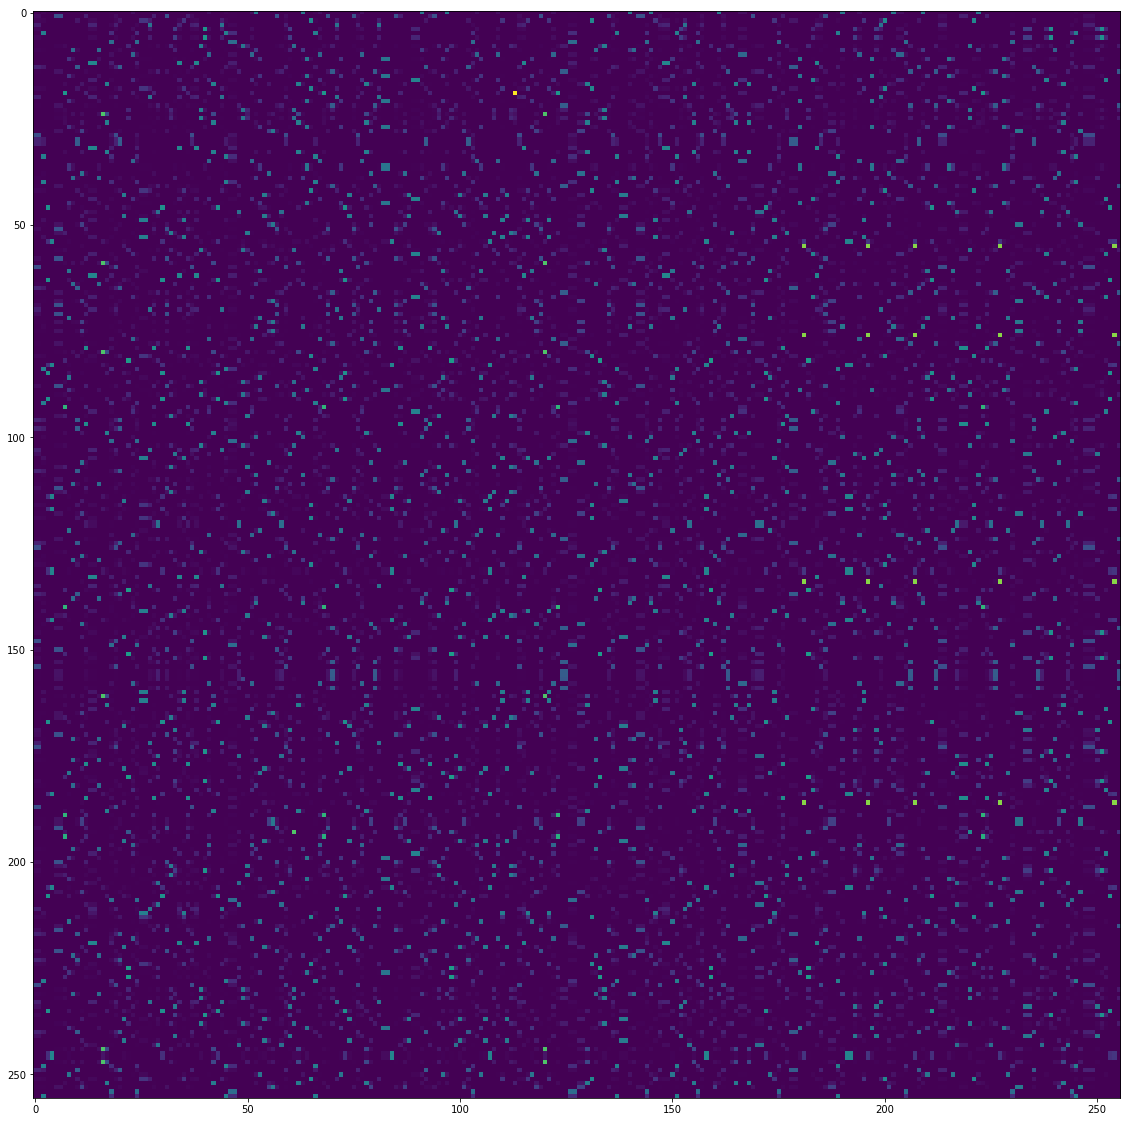

In [12]:
print(np.sum(ssp2[0,0,:,:], axis=1))
plt.figure(figsize=(20,20))
plt.imshow(ssp2[5,0,:,:])
print(ssp2[0,0,0,:])

In [13]:
print(np_x)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

In [14]:

joined_inf_hard = join_batch_split(unflatten_batch(o2, n_channels))

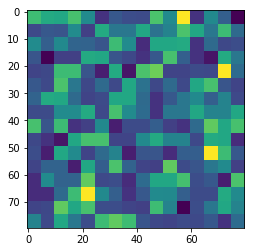

In [15]:
plt.imshow(joined_inf_hard[1,:,:,0])

In [16]:
print(np.mean(np.square(o2-np.reshape(real_images_split, [batch_size, n_squares, side_square**2])))*781)

90.45658789466769


In [17]:
print(rec_loss_np)

361.77243


In [18]:
print(o2[0,:,:])

[[0.30531946 0.30531946 0.30531946 ... 0.30531946 0.30531946 0.3053195 ]
 [0.37292677 0.37292677 0.37292677 ... 0.37292677 0.37292677 0.3729268 ]
 [0.3234476  0.3234476  0.3234476  ... 0.3234476  0.3234476  0.3234476 ]
 ...
 [0.33694732 0.33694732 0.33694732 ... 0.33694732 0.33694732 0.33694732]
 [0.22856376 0.22856376 0.22856376 ... 0.22856376 0.22856376 0.22856371]
 [0.3951081  0.3951081  0.3951081  ... 0.3951081  0.3951081  0.39510807]]
